In [3]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../')
from utils import *

# scperturb package
sys.path.insert(1, '../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../figures/')

In [8]:
TEMPDIR = Path('/scratch/peidli/scPerturb/JoungZhang2023')

In [9]:
file = TEMPDIR / 'GSE217460_210322_TFAtlas_S01-S04.csv'

In [ ]:
tab = pd.read_csv(file, index_col=0)

In [15]:
import dask.dataframe as ddf
tab = ddf.read_csv(file, sample=int(1e8))

KeyboardInterrupt: 

# NEW

In [12]:
import re
import h5py
from scipy.sparse import csr_matrix, vstack


In [13]:
atlas = TEMPDIR / 'GSE217460_210322_TFAtlas.h5ad'

In [14]:
f = h5py.File(atlas, "r")

In [15]:
chunk_size = 10000
iterations = int(np.ceil(f['X'].shape[0] / chunk_size) + 1)
chunks = [csr_matrix(f['X'][i*chunk_size:(i+1)*chunk_size]) for i in tqdm(range(iterations))]
X = vstack(chunks)
print('X.shape', X.shape)
# sparsity is high (~95% of entries are empty)
print(f'Sparsity: {np.round(100* X.count_nonzero() / np.product(X.shape), 2)}%')
# obs
keys = [k for k in f['obs'].keys() if not k.startswith('__')]
obs = pd.DataFrame(np.vstack([np.array(f['obs'][k]) for k in keys]).T, columns=keys)
obs.set_index('_index', inplace=True)
obs.index = obs.index.astype(str)
obs.index.name='cell_barcode'
# var
keys = [k for k in f['var'].keys() if not k.startswith('__')]
var = pd.DataFrame(np.vstack([np.array(f['var'][k]) for k in keys]).T, columns=keys)
var.set_index('_index', inplace=True)
var.index = var.index.astype(str)
var.index.name='gene_symbol'

# assemble
adata = sc.AnnData(X=X, obs=obs, var=var)

# set metadata
# TODO: Perturbation here is just a number. Find out what it means!!!
adata.obs = adata.obs.rename({'n_genes': 'ngenes', 'n_counts': 'ncounts', 'TF': 'perturbation'}, axis=1)
adata.obs['disease'] = "healthy"
adata.obs['cancer'] = False
adata.obs['tissue_type']="cell_line"
adata.obs["cell_line"] = "hESCs"
adata.obs["celltype"] = 'hESCs'
adata.obs['organism'] = 'human'
adata.obs['perturbation_type'] = 'ORF overexpression'
adata.obs['nperts'] = 1
annotate_qc(adata, species='human')
adata.obs.index.name = 'cell_barcode'

assert_annotations(adata)


100%|██████████| 116/116 [11:04<00:00,  5.73s/it]


X.shape (1145823, 37528)
Sparsity: 6.22%


In [21]:
adata.obs.perturbation = adata.obs.perturbation.astype(str)
adata.obs.batch = adata.obs.batch.astype(str)
adata.obs.louvain = adata.obs.louvain.astype(str)
adata.obs.ncounts = adata.obs.ncounts.astype(int)
adata.obs.ngenes = adata.obs.ngenes.astype(int)
adata.obs.percent_mito = adata.obs.percent_mito.astype(float)

In [23]:
adata.obs.percent_mito = adata.obs.percent_mito.astype(float)

In [24]:
adata.write(TEMPDIR / 'test.h5ad')

# mtx

In [13]:
keys = sorted([f.name.replace('_barcodes.tsv.gz', '') for f in path.glob('*_barcodes*')])

In [17]:
adata = sc.read_10x_mtx(path, prefix=keys[0]+'_')

In [18]:
adata

AnnData object with n_obs × n_vars = 10000 × 33538
    var: 'gene_ids', 'feature_types'

In [20]:
sorted([f.name for f in path.glob('*')])

['GSM6674255_191108_TFv2d56_4w_S1_barcodes.tsv.gz',
 'GSM6674255_191108_TFv2d56_4w_S1_features.tsv.gz',
 'GSM6674255_191108_TFv2d56_4w_S1_matrix.mtx.gz',
 'GSM6674256_191108_TFv2d56_4w_S2_barcodes.tsv.gz',
 'GSM6674256_191108_TFv2d56_4w_S2_features.tsv.gz',
 'GSM6674256_191108_TFv2d56_4w_S2_matrix.mtx.gz',
 'GSM6674257_191108_TFv2d56_8w_S1_barcodes.tsv.gz',
 'GSM6674257_191108_TFv2d56_8w_S1_features.tsv.gz',
 'GSM6674257_191108_TFv2d56_8w_S1_matrix.mtx.gz',
 'GSM6674258_191108_TFv2d56_8w_S2_barcodes.tsv.gz',
 'GSM6674258_191108_TFv2d56_8w_S2_features.tsv.gz',
 'GSM6674258_191108_TFv2d56_8w_S2_matrix.mtx.gz',
 'GSM6674380_200209_DS_S1_barcodes.tsv.gz',
 'GSM6674380_200209_DS_S1_features.tsv.gz',
 'GSM6674380_200209_DS_S1_matrix.mtx.gz',
 'GSM6674381_200209_DS_S2_barcodes.tsv.gz',
 'GSM6674381_200209_DS_S2_features.tsv.gz',
 'GSM6674381_200209_DS_S2_matrix.mtx.gz',
 'GSM6674382_200209_EB_S1_barcodes.tsv.gz',
 'GSM6674382_200209_EB_S1_features.tsv.gz',
 'GSM6674382_200209_EB_S1_matrix.mtx

In [26]:
df = pd.read_csv(path / 'GSM6719979_210322_TFmap_S10.csv.gz', index_col=0, header=None)

In [37]:
# get scRNA-seq from here!:
#https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE216463

,1,2
0,,
"R1.72,R2.27,R3.42",TGGTAGAGGGCCGAGAGCGTGTCG,14
"R1.94,R2.34,R3.60",GTCCATGGTCCATACGTGACGCAT,21
"R1.52,R2.85,R3.66",ACCCGTCGTTGCAATTGCATGCGA,407
"R1.02,R2.51,R3.77",TATTGCACTAGTGGCCGATGAGGA,82
"R1.49,R2.94,R3.02",ACGCGGTCCGTAGTCAGGATCCGC,417
...,...,...
"R1.45,R2.77,R3.35",ATATTTGCGGTGAGATGAGAGCAC,32
"R1.04,R2.69,R3.62",TCCAGAGCCTTCACGACGATCAGT,931
"R1.01,R2.45,R3.07",TTAACCATGCCACGCCTACATTGT,168


In [ ]:
# wget --recursive --no-parent -nd -R "index.html*" ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE216nnn/GSE216463/suppl/
# wget --recursive --no-parent -nd -R "index.html*" ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE216nnn/GSE216457/suppl/
# wget --recursive --no-parent -nd -R "index.html*" ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE216nnn/GSE216602/suppl/
# wget --recursive --no-parent -nd -R "index.html*" ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE216nnn/GSE216601/suppl/
# wget --recursive --no-parent -nd -R "index.html*" ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE216nnn/GSE216595/suppl/
# wget --recursive --no-parent -nd -R "index.html*" ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE217nnn/GSE217460/suppl/
# wget --recursive --no-parent -nd -R "index.html*" ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE217nnn/GSE217066/suppl/

In [23]:
GSE216463_keys = [x.name.replace('_matrix.mtx.gz', '') for x in TEMPDIR.glob('GSM66743*_matrix.mtx.gz')]
GSE216457_keys = [x.name.replace('_matrix.mtx.gz', '') for x in TEMPDIR.glob('GSM66742*_matrix.mtx.gz')]

In [34]:
GSE216463_keys

['GSM6674382_200209_EB_S1',
 'GSM6674381_200209_DS_S2',
 'GSM6674384_200209_RFX4_S1',
 'GSM6674380_200209_DS_S1',
 'GSM6674385_200209_RFX4_S2',
 'GSM6674383_200209_EB_S2']

In [29]:
adata = sc.read_10x_mtx(TEMPDIR, prefix=GSE216457_keys[0]+'_')

In [33]:
adata.var

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC233755.2,ENSG00000277856,Gene Expression
AC233755.1,ENSG00000275063,Gene Expression
AC240274.1,ENSG00000271254,Gene Expression
AC213203.1,ENSG00000277475,Gene Expression


In [30]:
bdata = sc.read_10x_mtx(TEMPDIR, prefix=GSE216463_keys[0]+'_')

In [32]:
bdata.obs

""
AAACCCAAGTGAGTTA-1
AAACCCACAACCGTAT-1
AAACCCACAACTCGTA-1
AAACCCACAGTCCCGA-1
AAACCCACATGGGAAC-1
...
TTTGTTGCACGACGCT-1
TTTGTTGCATATAGCC-1
TTTGTTGGTTTGTTCT-1
TTTGTTGTCGAGATGG-1


# H5ADs

In [ ]:
# relevant (having perturbations and controls) are:
# 'GSE217066_210715_combinatorial.h5ad'
# 'GSE217460_210322_TFAtlas.h5ad'

In [4]:
[x.name for x in TEMPDIR.glob('*h5ad')]

['GSE217066_210715_combinatorial.h5ad', 'GSE217460_210322_TFAtlas.h5ad']

## GSE216457_191108_TFv2d56 (no TFs)

In [128]:
adata = sc.read(TEMPDIR / 'GSE216457_191108_TFv2d56.h5ad')

In [129]:
adata

AnnData object with n_obs × n_vars = 26111 × 1237
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'celltype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

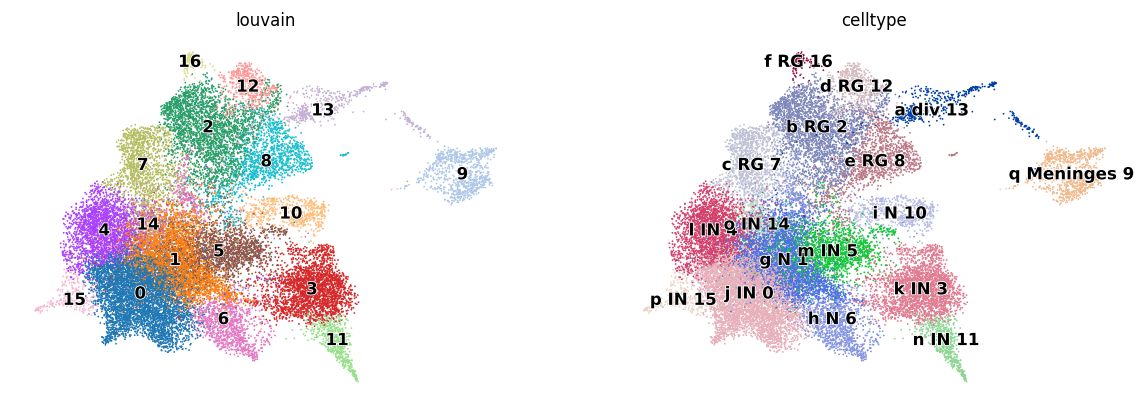

In [130]:
scv.pl.scatter(adata, dpi=120, color=['louvain', 'celltype'], legend_loc='on data')

## GSE217066_210715_combinatorial (working)

In [5]:
# this works on lots of RAM
tdata = sc.read_h5ad(TEMPDIR / 'GSE217066_210715_combinatorial.h5ad')

In [20]:
# their adata.X was scaled and their adata.raw.X was saved as dense...
# reconstruct unfiltered count matrix and make true sparse
from scipy.sparse import csr_matrix, vstack
adata = sc.AnnData(csr_matrix(tdata.raw.X), tdata.obs, tdata.raw.var, 
                   tdata.uns, tdata.obsm, obsp=tdata.obsp)

In [21]:
# clean up names
import re
adata.obs['perturbation'] = ['+'.join(sorted(re.sub(r'TFORF[0-9]{4}-', ' ', s).replace(' ','').split(','))) for s in adata.obs.TF]  # cleaner names

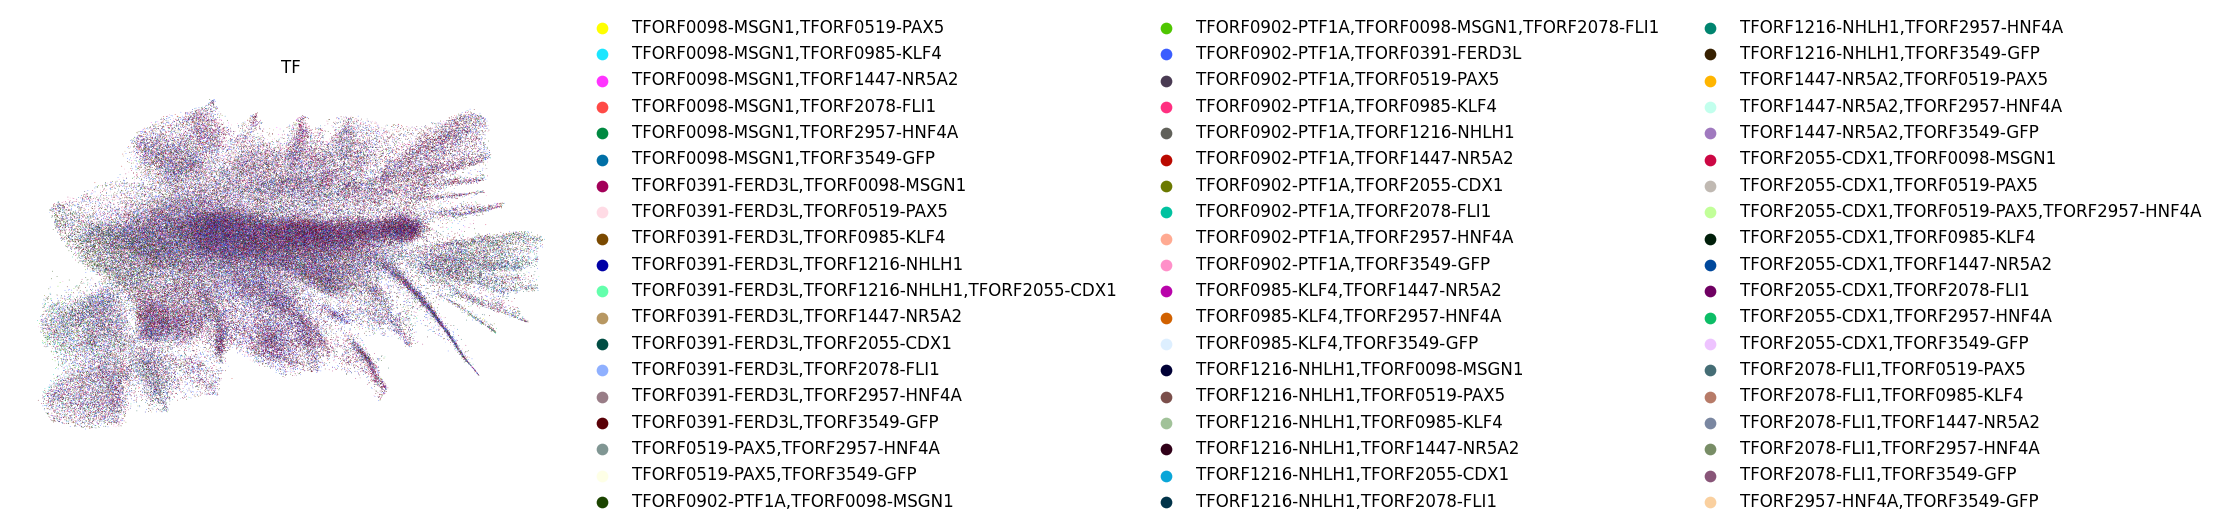

In [8]:
scv.pl.scatter(adata, basis='umap', color='TF', dpi=120, legend_loc='right margin')

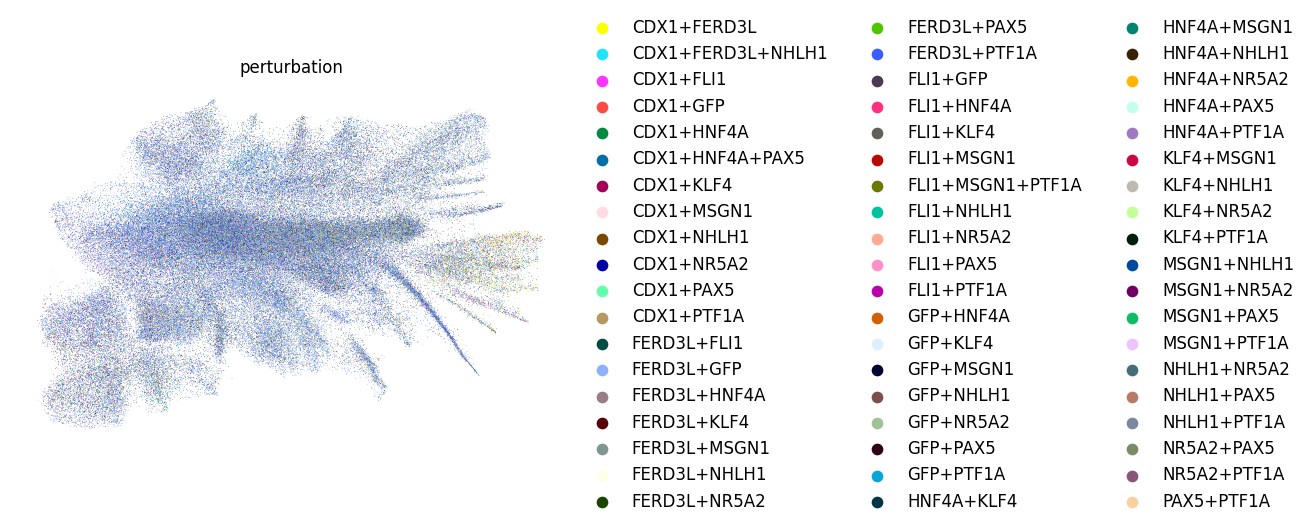

In [9]:
scv.pl.scatter(adata, basis='umap', color='perturbation', dpi=120, legend_loc='right margin')

In [23]:
adata

AnnData object with n_obs × n_vars = 167947 × 37302
    obs: 'n_genes', 'percent_mito', 'n_counts', 'batch', 'TF', 'louvain', 'perturbation'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'n_cells-4', 'n_cells-5', 'n_cells-6', 'n_cells-7', 'n_cells-8'
    uns: 'hvg', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [22]:
def adapt(adata):
    adata.obs = adata.obs.rename({'n_genes': 'ngenes', 'n_counts': 'ncounts'}, axis=1)
    adata.obs['disease'] = "healthy"
    adata.obs['cancer'] = False
    adata.obs['tissue_type']="cell_line"
    adata.obs["cell_line"] = "hESCs"
    adata.obs["celltype"] = 'hESCs'
    adata.obs['organism'] = 'human'
    adata.obs['perturbation_type'] = 'ORF overexpression'
    adata.obs['nperts'] = [p.count('+') + 1 - p.count('GFP') for p in adata.obs.perturbation]
    annotate_qc(adata, species='human')
    adata.obs.index.name = 'cell_barcode'
    return adata

In [16]:
[p.count('+') + 1 - p.count('GFP') for p in adata.obs.perturbation]

[1, 1]

In [18]:
[p for p in adata.obs.perturbation]

['perturbation', 'perturbation']

In [29]:
adata

AnnData object with n_obs × n_vars = 167947 × 37302
    obs: 'ngenes', 'percent_mito', 'ncounts', 'batch', 'TF', 'louvain', 'perturbation', 'disease', 'cancer', 'tissue_type', 'cell_line', 'celltype', 'organism', 'perturbation_type', 'nperts', 'percent_ribo'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'n_cells-4', 'n_cells-5', 'n_cells-6', 'n_cells-7', 'n_cells-8', 'ncounts', 'ncells'
    uns: 'hvg', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [24]:
adata = adapt(adata)

In [27]:
annotate_qc(adata, species='human')

In [28]:
assert_annotations(adata)

## GSE217460_210322_TFAtlas_differentiated (as subset of TFAtlas)

In [65]:
# clusters 6,7,8 of differentiated cells
bdata = sc.read_h5ad(TEMPDIR / 'GSE217460_210322_TFAtlas_differentiated.h5ad')

In [66]:
bdata

AnnData object with n_obs × n_vars = 28825 × 4806
    obs: 'TF', 'batch', 'louvain', 'n_counts', 'n_genes', 'percent_mito'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'diffmap_evals', 'hvg', 'iroot', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

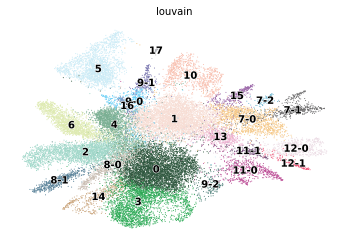

In [70]:
scv.pl.scatter(bdata, color='louvain', legend_loc='on data')

In [97]:
sorted(list([x.split('-',1)[-1] for x in bdata.obs.TF.unique()]))[-10:]

['ZSCAN31',
 'ZSCAN32',
 'ZSCAN5A',
 'ZSCAN5A',
 'ZSCAN9',
 'ZSCAN9',
 'ZXDA',
 'ZXDB',
 'ZZZ3',
 'mCherry']

In [105]:
bdata.obs['TF'] = [x.split('-',1)[1] for x in bdata.obs['TF']]
bdata.obs['TF_'] = bdata.obs.TF.copy().astype(str)
bdata.obs['TF_'][bdata.obs.TF.isin(['mCherry', 'GFP'])] = 'control'

In [106]:
sdata = equal_subsampling(bdata, 'TF', N_min=50)
ed = edist(sdata, 'TF')
ed = cluster_matrix(ed, 'both')

100%|██████████| 135/135 [00:37<00:00,  3.62it/s]


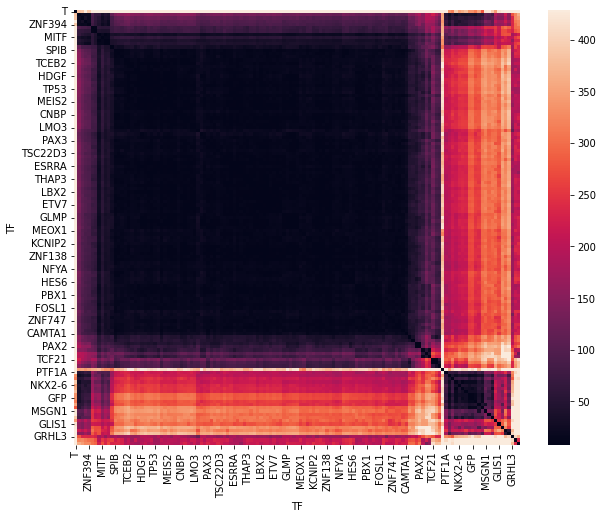

In [108]:
fig, ax = pl.subplots(1,1, figsize=[10,8])
sns.heatmap(ed, robust=True)
pl.show()

In [109]:
et = etest(sdata, 'TF_', control='control')

100%|██████████| 100/100 [00:06<00:00, 14.45it/s]


In [110]:
et

,edist,pvalue,significant,pvalue_adj,significant_adj
ASCL3,43.814369,0.00,True,0.0000,True
ASCL4,19.800642,0.00,True,0.0000,True
ATF3,306.181631,0.00,True,0.0000,True
ATOH7,24.479199,0.00,True,0.0000,True
BATF2,290.351385,0.00,True,0.0000,True
...,...,...,...,...,...
ZNF747,242.473264,0.00,True,0.0000,True
ZNF788,278.192942,0.00,True,0.0000,True
ZSCAN2,255.808771,0.00,True,0.0000,True
ZSCAN9,12.738147,0.19,False,0.3439,False


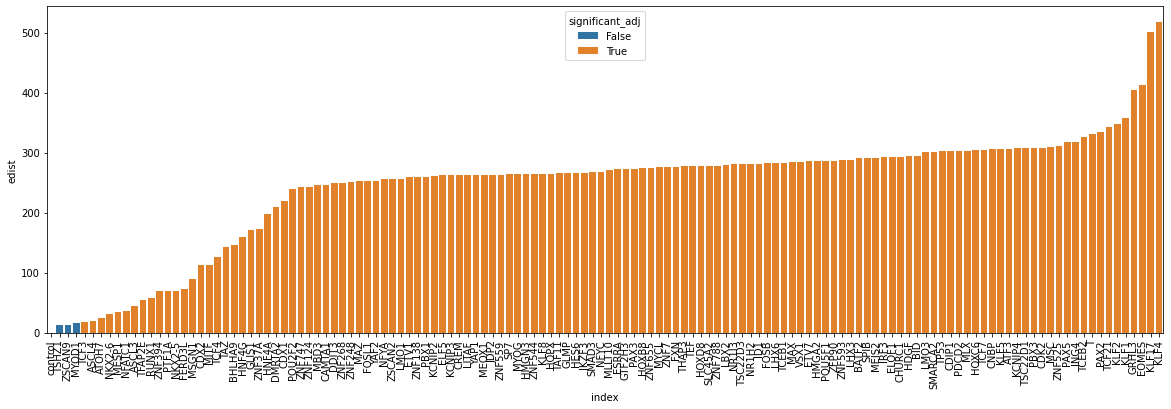

In [117]:
pl.figure(figsize=(20,6))
sns.barplot(data=et.reset_index(), x='index', y='edist', hue='significant_adj', dodge=False, order=et.sort_values('edist').index)
pl.xticks(rotation=90)
pl.show()

## GSE217460_210322_TFAtlas(_subsample) FAILS

In [43]:
# not loadable
tab = pd.read_csv(TEMPDIR / 'GSE217460_210322_TFAtlas_S01-S04.csv', usecols=[0,1,2,3,4,5])

KeyboardInterrupt: 

In [ ]:
tab.head()

In [30]:
import anndata as ad
ad.__version__

'0.8.0'

In [31]:
# this fails, tested in anndata v0.8.0
# cdata = ad.read_h5ad(TEMPDIR / 'GSE217460_210322_TFAtlas.h5ad')
# AnnDataReadError: Above error raised while reading key '/X' of type <class 'h5py._hl.dataset.Dataset'> from /. 

In [32]:
import h5py
f = h5py.File(TEMPDIR / 'GSE217460_210322_TFAtlas.h5ad', "r")
list(f.keys())

['X', 'obs', 'var']

In [33]:
# get obs
keys = [k for k in f['obs'].keys() if not k.startswith('__')]
obs = pd.DataFrame(np.vstack([np.array(f['obs'][k]) for k in keys]).T, columns=keys)
obs.set_index('_index', inplace=True)
obs.index = obs.index.astype(str)
obs.index.name='cell_barcode'

# get vars
keys = [k for k in f['var'].keys() if not k.startswith('__')]
var = pd.DataFrame(np.vstack([np.array(f['var'][k]) for k in keys]).T, columns=keys)
var.set_index('_index', inplace=True)
var.index = var.index.astype(str)
var.index.name='gene_symbol'

In [34]:
len(obs), len(var)

(1145823, 37528)

In [38]:
obs.TF.max()

3368

In [41]:
obs.TF

cell_barcode
R1.01,R2.01,R3.01,P1.22-0-0     802
R1.01,R2.01,R3.02,P1.22-0-0    1620
R1.01,R2.01,R3.05,P1.38-0-0     121
R1.01,R2.01,R3.09,P1.46-0-0    1913
R1.01,R2.01,R3.10,P1.22-0-0     389
                               ... 
R1.96,R2.96,R3.45,P1.62-3-1    3368
R1.96,R2.96,R3.58,P1.62-3-1    3368
R1.96,R2.96,R3.79,P1.62-3-1    3368
R1.96,R2.96,R3.85,P1.62-3-1     469
R1.96,R2.96,R3.87,P1.62-3-1    2538
Name: TF, Length: 1145823, dtype: object

In [19]:
f['X']  # this is not sparse

<HDF5 dataset "X": shape (1145823, 37528), type "<f4">

In [18]:
# could have been saved as sparse though...
f['X'][0,:]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [10]:
from scipy.io import mmwrite

In [11]:
from pathlib import Path
Path('/fast/scratch/users/peidlis_c/perturbation_resource_paper/chunks/').mkdir(parents=True, exist_ok=True)

In [37]:
f['X'].shape

(1145823, 37528)

In [22]:
obs.shape

(1145823, 6)

In [13]:
# convert to sparse in a chunked fashion
from scipy.sparse import csr_matrix

# We load the original dense data per chunk and convert each to sparse (csr) right on the spot
# This avoids loading all data as dense into memory (too big)
chunk_size = 10000
iterations = int(np.ceil(f['X'].shape[0] / 10000) + 1)
for i in tqdm(range(iterations)):
    chunk = csr_matrix(f['X'][i*chunk_size:(i+1)*chunk_size])
    mmwrite(f'/fast/scratch/users/peidlis_c/perturbation_resource_paper/chunks/{i}_chunk.mtx', chunk)

 29%|██▉       | 34/116 [18:19<44:11, 32.33s/it]


KeyboardInterrupt: 

In [34]:
# convert to sparse in a chunked fashion
from scipy.sparse import csr_matrix

# We load the original dense data per chunk and convert each to sparse (csr) right on the spot
# This avoids loading all data as dense into memory (too big)
chunk_size = 10000
iterations = int(np.ceil(f['X'].shape[0] / chunk_size) + 1)
i = iterations - 10
csr_matrix(f['X'][i*chunk_size:(i+1)*chunk_size])

<10000x37528 sparse matrix of type '<class 'numpy.float32'>'
	with 20165229 stored elements in Compressed Sparse Row format>

In [36]:
iterations

116

In [33]:
10600000 - f['X'].shape[0]

9454177

In [31]:
i*chunk_size, (i+1)*chunk_size

(10600000, 10700000)

In [ ]:
from scipy.sparse import vstack
X = vstack(chunks)

# sparsity is high (~95% of entries are empty)
print(f'Sparsity: {np.round(100* X.count_nonzero() / np.product(X.shape), 2)}%')

## GSE216595_180124_perturb (no control)

In [136]:
# Fig S4I
ddata = sc.read(TEMPDIR / 'GSE216595_180124_perturb.h5ad')
ddata

AnnData object with n_obs × n_vars = 60997 × 5047
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'TF', 'louvain', 'temp'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'temp_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [148]:
sorted(list(ddata.obs.TF.unique()))

['ARX-NM_139058',
 'ASCL1-NM_004316',
 'BCL11A-NM_022893',
 'BCL11A-NM_138559',
 'BRIP1-NM_032043',
 'CDK1-NM_001170407',
 'CDK1-NM_001786',
 'CENPA-NM_001042426',
 'CHAF1A-NM_005483',
 'CXXC1-NM_014593',
 'E2F1-NM_005225',
 'E2F2-NM_004091',
 'E2F7-NM_203394',
 'E2F8-NM_001256372',
 'EGR1-NM_001964',
 'EMX2-NM_001165924',
 'EMX2-NM_004098',
 'ENO1-NM_001201483',
 'ENO1-NM_001428',
 'EOMES-NM_001278183',
 'EOMES-NM_005442',
 'FEZF2-NM_018008',
 'FOS-NM_005252',
 'FOXG1-NM_005249',
 'FOXM1-NM_001243089',
 'FOXM1-NM_202003',
 'FOXN4-NM_213596',
 'GLI3-NM_000168',
 'H2AFX-NM_002105',
 'HELLS-NM_001289068',
 'HELLS-NM_001289073',
 'HES1-NM_005524',
 'HES5-NM_001010926',
 'HMGB1-NM_002128',
 'HMGB2-NM_002129',
 'HOPX-NM_139212',
 'ID3-NM_002167',
 'ID4-NM_001546',
 'INSM1-NM_002196',
 'KLF15-NM_014079',
 'LHX2-NM_004789',
 'MAZ-NM_001276275',
 'MAZ-NM_001276276',
 'MEIS1-NM_002398',
 'MXD3-NM_001142935',
 'MXD3-NM_031300',
 'MYBL2-NM_001278610',
 'NFATC4-NM_001198966',
 'NFATC4-NM_001288802

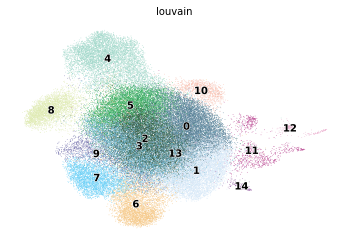

In [141]:
scv.pl.scatter(ddata, color='louvain')

## GSE216601_180525_CM (no ORFs)

In [137]:
# Fig S5F
edata = sc.read(TEMPDIR / 'GSE216601_180525_CM.h5ad')
edata

AnnData object with n_obs × n_vars = 16698 × 3579
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

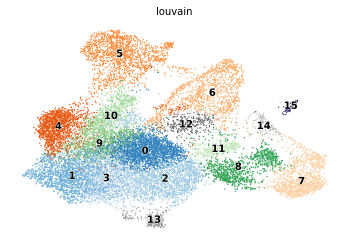

In [142]:
scv.pl.scatter(edata, color='louvain')